# First look at using database to quickly graph potential metrics

# list of possible metrics

https://pmc.ncbi.nlm.nih.gov/articles/PMC5624990/
- to maybe add to analysis:
    - distribution of RR intervals
    - RR poincaré plot


- Average HR over whole time
- Average HR by week
- Average HR by month
- HR range per day
- HR max per day
- HRV standard dev. per day
- mean of the standard devs.
- HRV average per day
- average HR during activity
    - HRV standard dev. during days with activity
    - max and min HR on days with activity
    - HRV standard dev. during nights after activity
    - max and min HR during nights after activity
    - resting HR on days with activity
- resting HR per week
- resting HR per month
- resting HR per day
- scaling exponent difference after crossover
- crossover point against length of time measured
- crossover point average and standard dev. for healthy and unhealthy
- difference in resting and average hr per day


# DFA on PPG

it turns out that there is a library that does this. so i can try and implement it but its possible it wont work well with 1/HR and may be better to find peaks of HR PPG?

# Average standard deviation in PPG HRV per day

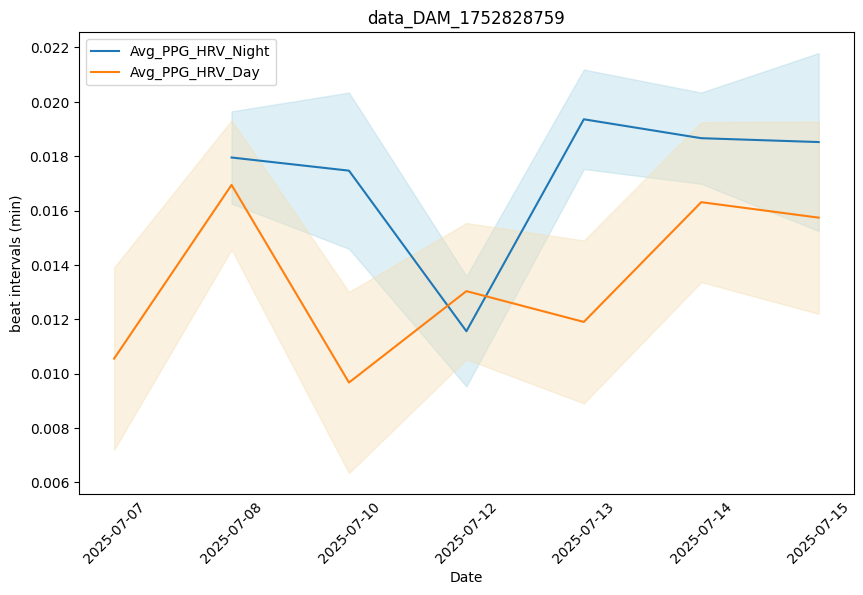

In [63]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
db_name='volunteer_metrics.db'
patient_ID='data_DAM_1752828759'
con=sqlite3.connect(db_name)
cur=con.cursor()
test_data=cur.execute("SELECT Night_Vitals.Std_PPG_HRV_Night,Daily_Vitals.Std_PPG_HRV_Day,Night_Vitals.Avg_PPG_HRV_Night,Daily_Vitals.Avg_PPG_HRV_Day,\
    Daily_Vitals.Date FROM Daily_Vitals INNER JOIN Night_Vitals on Daily_Vitals.Date_Vitals=Night_Vitals.Date_Vitals WHERE Daily_Vitals.Patient_ID=?", (patient_ID,)).fetchall()
c=[description[0] for description in cur.description]
df=pd.DataFrame(test_data,columns=c)

fig,ax=plt.subplots(figsize=(10,6))
df.plot(x=c[-1],y=c[2:-1],ax=ax,ylabel='beat intervals (min)',title=patient_ID)
ax.fill_between(x=df['Date'],y1=df['Avg_PPG_HRV_Night']-df['Std_PPG_HRV_Night'],y2=df['Avg_PPG_HRV_Night']+df['Std_PPG_HRV_Night'],alpha=0.4,color='lightblue')
ax.fill_between(x=df['Date'],y1=df['Avg_PPG_HRV_Day']-df['Std_PPG_HRV_Day'],y2=df['Avg_PPG_HRV_Day']+df['Std_PPG_HRV_Day'],alpha=0.4,color='wheat')
ax.tick_params(axis='x',labelrotation=45,length=0.1)

# Average HR during activity

In [69]:
cur=con.cursor()
test_data=cur.execute("SELECT Activities.Avg_Active_HR ,Daily_Vitals.Date FROM Activities INNER JOIN Daily_Vitals on\
                     Activities.Date_Vitals=Daily_Vitals.Date_Vitals WHERE Daily_Vitals.Patient_ID=?", (patient_ID,)).fetchall()
c=[description[0] for description in cur.description]
df=pd.DataFrame(test_data,columns=c)
fig,ax=plt.subplots(figsize=(10,6))
plt.suptitle('HR during activity')
df.plot(x=c[-1],y=c[:-1],ax=ax,ylabel='Heart Rate (BPM)',title=patient_ID)
ax.tick_params(axis='x',labelrotation=45,length=0.1)

In [68]:
cur=con.cursor()
test_data=cur.execute("SELECT Daily_Vitals.* FROM (Daily_Vitals INNER JOIN Dates ON Daily_Vitals.Date=Dates.Date) INNER JOIN Weeks on Dates.Week=Weeks.Week WHERE Weeks.Week=?",('2025-W28',)).fetchall()
c=[description[0] for description in cur.description]
df=pd.DataFrame(test_data,columns=c)
print(df)

   Date_Vitals           Patient_ID        Date  Day_avg_HR  Day_min_HR  \
0            1  data_DAM_1752828759  2025-07-07  105.731500        51.0   
1            2  data_DAM_1752828759  2025-07-08   60.635593        47.0   
2            3  data_DAM_1752828759  2025-07-09   89.879802        43.0   
3            4  data_DAM_1752828759  2025-07-10  114.314629        45.0   
4            5  data_DAM_1752828759  2025-07-11   71.423729        45.0   
5            6  data_DAM_1752828759  2025-07-12   79.991935        56.0   
6            7  data_DAM_1752828759  2025-07-13   89.035956        42.0   

   Day_max_HR  Resting_HR  Avg_PPG_HRV_Day  Std_PPG_HRV_Day  
0       190.0         NaN         0.010555         0.003351  
1       123.0        52.0         0.016941         0.002378  
2       181.0        46.4         0.011909         0.003075  
3       185.0        49.6         0.009674         0.003329  
4       184.0        48.6         0.015079         0.003735  
5       139.0        69.0  

# average HR over whole period

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
db_name='patient_metrics.db'
con=sqlite3.connect(db_name)
cur=con.cursor()
overall_avg_HR_data=cur.execute("SELECT overall_HR_avg,Patient_ID FROM Patients").fetchall()
c=[description[0] for description in cur.description]
df=pd.DataFrame(overall_avg_HR_data,columns=c)
fig,ax=plt.subplots(figsize=(10,6))
df.plot(kind='box',x=c[-1],y=c[:-1],ax=ax,ylabel='Heart rate (Bpm)',title='average HR')
ax.tick_params(axis='x',labelrotation=45,length=0.1)
jitter = np.random.normal(loc=0, scale=0.05, size=len(df['overall_HR_avg']))
viridis=plt.colormaps['viridis']
plt.scatter(np.ones_like(df['overall_HR_avg']) + jitter/10, df['overall_HR_avg'], alpha=0.5, c=np.arange(len(df['Patient_ID'])),cmap=viridis,zorder=3, s=40,label=c[-1])

ValueError: Expected the given number of height ratios to match the number of rows of the grid

<Figure size 1000x600 with 0 Axes>

# HR per week

In [19]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
db_name='patient_metrics.db'
con=sqlite3.connect(db_name)

def func(x,m,c):
    return m*x+c

def weeks(con,ax,datatype=''):
    cur=con.cursor()
    Patients=np.concatenate(np.array(cur.execute("SELECT Patient_ID FROM Patients").fetchall()))
    Weeks=np.unique(np.concatenate(np.array(cur.execute("SELECT Week FROM Weeks").fetchall())))
    week_index={week: i for i, week in enumerate(Weeks)}
    viridis=plt.colormaps['viridis']
    new_colors=viridis(np.linspace(0,1,len(Patients)))

    for i,p in enumerate(Patients):
        weeks_hr=cur.execute("SELECT Weeks_HR.* FROM Patients INNER JOIN Weeks_HR ON Patients.Patient_ID=Weeks_HR.Patient_ID WHERE Patients.Patient_ID=?",(p,)).fetchall()
        c=[description[0] for description in cur.description]
        df=pd.DataFrame(weeks_hr,columns=c)
        df['week_index']=df[c[1]].map(week_index)
        ax.scatter(x=df['week_index'],y=df[c[-1]],color=new_colors[i],label=f'patient {p}',zorder=2)
        try:
            popt,pcovr=curve_fit(func,xdata=np.arange(len(df[c[1]])),ydata=df[c[-1]])
            x=np.arange(len(df['week_index']))
            ax.plot(df['week_index'],popt[0]*x+popt[1],color=new_colors[i])
        except:
            pass
    ax.set_xticks(list(week_index.values()))
    ax.set_xticklabels(list(week_index.keys()), rotation=90)
    ax.tick_params(axis='x',length=0.1, width=0.1)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    ax.set_xlabel('Weeks')
    ax.set_ylabel('Heart rate (Bpm)')
    ax.set_title(f'Average HR per week - {datatype}')
    ax.grid()

fig,ax=plt.subplots(2,1,figsize=(12,12),gridspec_kw={'height_ratios': [7,5]})
fig.tight_layout(pad=8.0)
weeks(con,ax[0],'patients')
db_name='volunteer_metrics.db'
con=sqlite3.connect(db_name)
weeks(con,ax[1],'volunteers')





/tmp/ipykernel_581953/838109665.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcovr=curve_fit(func,xdata=np.arange(len(df[c[1]])),ydata=df[c[-1]])


# poincare metrics

In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
db_name='patient_metrics.db'
con=sqlite3.connect(db_name)
cur=con.cursor()
poincare_data=cur.execute("SELECT Patient_ID,sd1,sd2,sd_ratio,ellipse_area FROM Patients").fetchall()
c=[description[0] for description in cur.description]
df=pd.DataFrame(poincare_data,columns=c)
df.plot(kind='hist',x=c[0],y=c[-1])

<Axes: ylabel='Frequency'>

# DFA stuff

In [173]:
def fetching_DFA_data(db_name):
    #PPG
    con=sqlite3.connect(db_name)
    cur1=con.cursor()
    PPG_DFA_data=cur1.execute("SELECT Patient_ID,scaling_exponent_noise,scaling_exponent_linear,crossover_PPG FROM Patients").fetchall()
    c=[description[0] for description in cur1.description]
    PPG_df=pd.DataFrame(PPG_DFA_data,columns=c)
    PPG_df['exponent_diff']=PPG_df['scaling_exponent_linear']-PPG_df['scaling_exponent_noise']

    #ECG
    cur2=con.cursor()
    ECG_DFA_data=cur2.execute("SELECT Patient_ID,ECG_scaling_exponent_noise,ECG_scaling_exponent_linear,crossover_ECG FROM Patients").fetchall()
    c=[description[0] for description in cur2.description]
    ECG_df=pd.DataFrame(ECG_DFA_data,columns=c)
    ECG_df['exponent_diff']=ECG_df['ECG_scaling_exponent_linear']-ECG_df['ECG_scaling_exponent_noise']

    con.close()

    return PPG_df,ECG_df


def plot_PPG_data(PPG_df,ax,datatype=''):
    x_axis=np.array(PPG_df['Patient_ID'])
    se_noise=np.array(PPG_df['scaling_exponent_noise'],dtype=np.float64)
    se_linear=np.array(PPG_df['scaling_exponent_linear'],dtype=np.float64)
    diff=np.array(PPG_df['exponent_diff'],dtype=np.float64)
    ax.set_title(f'Trend–Noise DFA Exponent Differences in Smartwatch PPG Data - {datatype}')
    ax.scatter(x_axis,se_noise,marker='d',color='orange',label='noise dominant - PPG')
    ax.scatter(x_axis,se_linear,marker='D',color='blue',label='trend dominant - PPG')
    ax.tick_params(axis='x',labelrotation=-90,length=0.1)
    ax.scatter(x_axis,diff,marker='p',color='red',label='trend-noise - PPG')
    ax.vlines(x_axis,diff,0,color='red')
    ax.axhline(0,color='k')
    ax.set_xlabel('patient number')
    ax.set_ylabel('scaling exponents')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    
def plot_ECG_data(ECG_df,ax,datatype=''):
    x_axis=np.array(ECG_df['Patient_ID'])
    se_noise=np.array(ECG_df['ECG_scaling_exponent_noise'],dtype=np.float64)
    se_linear=np.array(ECG_df['ECG_scaling_exponent_linear'],dtype=np.float64)
    diff=np.array(ECG_df['exponent_diff'],dtype=np.float64)
    ax.set_title(f'Trend–Noise DFA Exponent Differences in Smartwatch ECG Data - {datatype}')
    ax.scatter(x_axis,se_noise,marker='d',color='orange',label='noise dominant - ECG')
    ax.scatter(x_axis,se_linear,marker='D',color='blue',label='trend dominant - ECG')
    ax.tick_params(axis='x',labelrotation=-90,length=0.1)
    ax.scatter(x_axis,diff,marker='p',color='red',label='trend-noise - ECG')
    ax.vlines(x_axis,diff,0,color='red')
    ax.axhline(0,color='k')
    ax.set_xlabel('patient number')
    ax.set_ylabel('scaling exponents')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

def violin_plots(PPG,ECG,ax,datatype=''):
    v1=ax.violinplot(PPG,positions=[1],showmedians=True,showmeans=False,showextrema=True)
    v2=ax.violinplot(ECG,positions=[2],showmedians=True,showmeans=False,showextrema=True)
    ax.legend([v1['bodies'][0],v2['bodies'][0]], [ 'PPG data','ECG data'], loc=3)
    ax.set_title(f'violin plots of trend-noise - {datatype}')
    ax.set_ylabel('trend-noise')
    

In [89]:
from scipy.stats import ttest_1samp, ttest_rel
def t_test(data,null):
    if type(null)==int:
        t_stat, p_value = ttest_1samp(data,null,nan_policy='omit')
    else:
        t_stat, p_value = ttest_rel(data,null,nan_policy='omit')
    if p_value<0.05:
        print('t-test result is there is evidence to reject the null hypothesis with a p value of {}'.format(p_value))
    else:
        print('t-test result is that we cannot reject the null hypothesis with p value of {}'.format(p_value))
    return t_stat,p_value

----------------------------------------------------------------------
testing PPG patient exponent difference with null hypothesis of mean=0
t-test result is there is evidence to reject the null hypothesis with a p value of 0.0001685187812057343
----------------------------------------------------------------------
testing ECG patient exponent difference with null hypothesis of mean=0
t-test result is there is evidence to reject the null hypothesis with a p value of 7.784408409845584e-11
----------------------------------------------------------------------
testing PPG volunteer exponent difference with null hypothesis of mean=0
t-test result is there is evidence to reject the null hypothesis with a p value of 0.040183530375001275
----------------------------------------------------------------------
testing ECG volunteer exponent difference with null hypothesis of mean=0
t-test result is that we cannot reject the null hypothesis with p value of 0.2561770498703736
--------------------

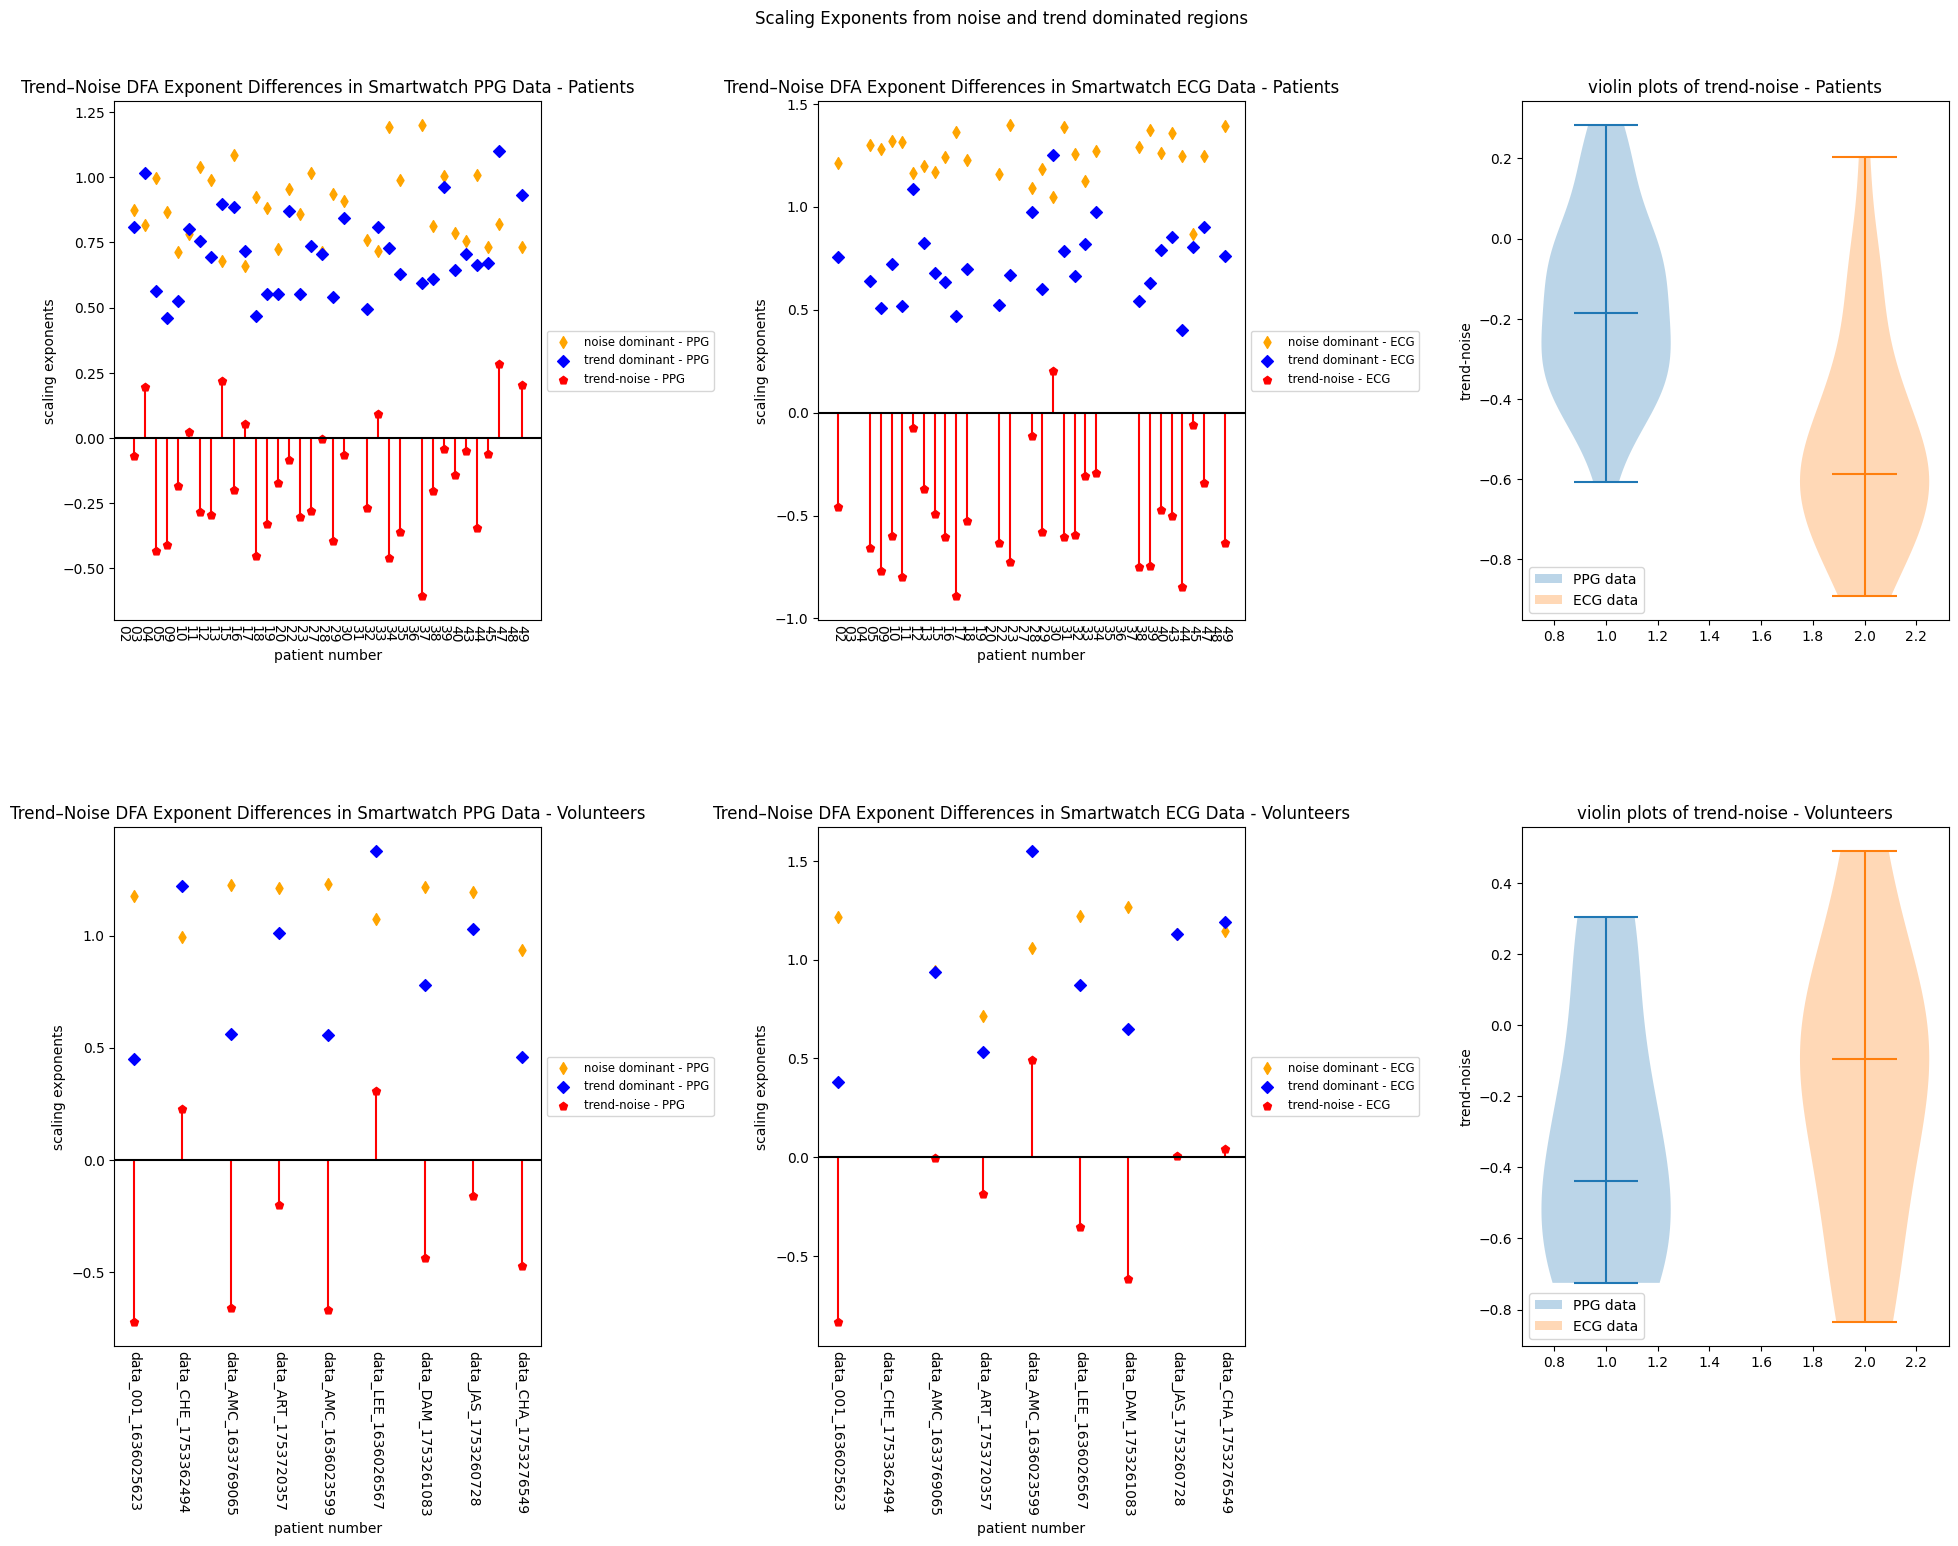

In [174]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# getting patient DFA data

db_name='patient_metrics.db'
Patient_PPG_df,Patient_ECG_df=fetching_DFA_data(db_name=db_name)

# getting volunteer DFA data

db_name='volunteer_metrics.db'
Volunteer_PPG_df,Volunteer_ECG_df=fetching_DFA_data(db_name=db_name)

# plotting patient data
fig,ax=plt.subplots(2,3,figsize=(20,16),gridspec_kw={'height_ratios': [10,10]})
plot_PPG_data(Patient_PPG_df,ax[0][0],'Patients')
plot_ECG_data(Patient_ECG_df,ax[0][1],'Patients')
plot_PPG_data(Volunteer_PPG_df,ax[1][0],'Volunteers')
plot_ECG_data(Volunteer_ECG_df,ax[1][1],'Volunteers')
fig.suptitle('Scaling Exponents from noise and trend dominated regions')
plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=0.4)

# stats calculations
print('----------------------------------------------------------------------')
print('testing PPG patient exponent difference with null hypothesis of mean=0')
Patient_PPG_diff=np.array(Patient_PPG_df['exponent_diff'],dtype=np.float64)
t_test(Patient_PPG_diff,0)
print('----------------------------------------------------------------------')
print('testing ECG patient exponent difference with null hypothesis of mean=0')
Patient_ECG_diff=np.array(Patient_ECG_df['exponent_diff'],dtype=np.float64)
t_test(Patient_ECG_diff,0)
print('----------------------------------------------------------------------')
print('testing PPG volunteer exponent difference with null hypothesis of mean=0')
Volunteer_PPG_diff=np.array(Volunteer_PPG_df['exponent_diff'],dtype=np.float64)
t_test(Volunteer_PPG_diff,0)
print('----------------------------------------------------------------------')
print('testing ECG volunteer exponent difference with null hypothesis of mean=0')
Volunteer_ECG_diff=np.array(Volunteer_ECG_df['exponent_diff'],dtype=np.float64)
t_test(Volunteer_ECG_diff,0)
print('----------------------------------------------------------------------')
print('\n\n\n----------------------------------------------------------------------')
print('testing PPG patient exponent difference with null hypothesis of ECG exponent difference')
t_test(Patient_ECG_diff,Patient_PPG_diff)
print('----------------------------------------------------------------------')
print('testing PPG volunteer exponent difference with null hypothesis of ECG exponent difference')
t_test(Volunteer_ECG_diff,Volunteer_PPG_diff)
print('----------------------------------------------------------------------')

Patient_ECG_diff=Patient_ECG_diff[~np.isnan(Patient_ECG_diff)]
Patient_PPG_diff=Patient_PPG_diff[~np.isnan(Patient_PPG_diff)]
Volunteer_ECG_diff=Volunteer_ECG_diff[~np.isnan(Volunteer_ECG_diff)]
Volunteer_PPG_diff=Volunteer_PPG_diff[~np.isnan(Volunteer_PPG_diff)]

violin_plots(Patient_PPG_diff,Patient_ECG_diff,ax[0][2],'Patients')
violin_plots(Volunteer_PPG_diff,Volunteer_ECG_diff,ax[1][2],'Volunteers')


# Daily Vitals

In [20]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
from ipywidgets import interact

db_name='patient_metrics.db'
con1=sqlite3.connect(db_name)
db_name2='volunteer_metrics.db'
con2=sqlite3.connect(db_name2)
def func(x,m,c):
    return m*x+c

def Daily_PPG(con,metric_to_plot):
    # for idx,p in enumerate(Patients):
    cur2=con.cursor()
    Daily_data=cur2.execute("SELECT Daily_Vitals.* FROM Patients INNER JOIN Daily_Vitals on Patients.Patient_ID=Daily_Vitals.Patient_ID").fetchall()
    c=[description[0] for description in cur2.description]
    Daily_data_df=pd.DataFrame(Daily_data,columns=c)
    Daily_data_df=Daily_data_df.drop(columns=['Date_Vitals'])
    Daily_data_df['datetimes']=pd.to_datetime(Daily_data_df['Date'])
    Daily_data_df['Day_since_start'] = Daily_data_df.groupby('Patient_ID')['datetimes'].transform(lambda x: (x - x.min()).dt.days)

    pivot = Daily_data_df.pivot_table(
        index='Patient_ID', 
        columns='Day_since_start', 
        values=metric_to_plot
    )
    fig,ax=plt.subplots(2,1,figsize=(20,8),layout='constrained')
    fig.suptitle(metric_to_plot)
    sns.heatmap(pivot,cmap='viridis',annot=False,ax=ax[0])
    ax[0].tick_params(axis='x',length=0.1, rotation=90)
    # ax[0].set_yticks([])
    ax[0].set_title(f'heat map of {metric_to_plot} per day')
    average_trend(pivot,ax[1])

    

def average_trend(pivot,ax):
    
    avg_trend=pivot.mean(axis=0)
    std_trend=pivot.std(axis=0)
    nan_mask=~np.isnan(std_trend.values)
    avg_trend=avg_trend[nan_mask]
    std_trend=std_trend[nan_mask]
    ax.plot(avg_trend.index,avg_trend.values,label='Mean with std dev')
    ax.fill_between(avg_trend.index,avg_trend.values+std_trend.values,avg_trend.values-std_trend.values,alpha=0.3)
    ax.legend()
    ax.set_title('average with standard deviation')
    ax.set_xlabel('days since start')
    ax.set_ylabel('mean per day')


def Daily_ECG(con,metric_to_plot):
    cur=con.cursor()
    Daily_data=cur.execute("SELECT Patients.Patient_ID,ECG_Vitals.Date_Plus_Hour,ECG_Vitals.Avg_ECG_HRV,ECG_Vitals.Std_ECG_HRV FROM (Patients INNER JOIN Daily_Vitals on Patients.Patient_ID=Daily_Vitals.Patient_ID)INNER JOIN ECG_Vitals on Patients.Patient_ID=Daily_Vitals.Patient_ID").fetchall()
    c=[description[0] for description in cur.description]
    Daily_data_df=pd.DataFrame(Daily_data,columns=c)
    Daily_data_df['datetimes']=pd.to_datetime(Daily_data_df['Date_Plus_Hour'], format='%Y-%m-%d:%H', errors='coerce')
    Daily_data_df['Day_since_start'] = Daily_data_df.groupby('Patient_ID')['datetimes'].transform(lambda x: (x - x.min()).dt.days)

    print(Daily_data_df.groupby(by='Day_since_start')[['Avg_ECG_HRV','Std_ECG_HRV']].mean())
    # pivot = Daily_data_df.pivot_table(
    #     index='Patient_ID', 
    #     columns='Day_since_start', 
    #     values=metric_to_plot
    # )
    # fig,ax=plt.subplots(2,1,figsize=(20,8),layout='constrained')
    # fig.suptitle(metric_to_plot)
    # sns.heatmap(pivot,cmap='viridis',annot=False,ax=ax[0])
    # ax[0].tick_params(axis='x',length=0.1, rotation=90)
    # ax[0].set_title(f'heat map of {metric_to_plot} per day')
    # average_trend(pivot,ax[1])



Daily_ECG(con1,'')

interact(Daily_PPG,con=[con1,con2],metric_to_plot=['Std_PPG_HRV_Day','Avg_PPG_HRV_Day','Day_max_HR','Day_min_HR','Day_avg_HR'])



                 Avg_ECG_HRV  Std_ECG_HRV
Day_since_start                          
0                   0.733076     0.053648
1                   0.738956     0.039361
2                   0.849606     0.057722
3                   0.886284     0.075109
4                   0.821607     0.063730
...                      ...          ...
565                 0.674228     0.083796
566                 0.771429     0.022877
567                      NaN          NaN
568                      NaN          NaN
569                      NaN          NaN

[535 rows x 2 columns]


interactive(children=(Dropdown(description='con', options=(<sqlite3.Connection object at 0x7f245cddd6c0>, <sql…

<function __main__.Daily_PPG(con, metric_to_plot)>

In [ ]:
from ipywidgets import interact

def testing_interact(x):
    return x



interactive(children=(Dropdown(description='x', options=('apples', 'oranges'), value='apples'), Output()), _do…

<function __main__.testing_interact(x)>